## Image Inpainting using OpenVINO
This notebook demonstrates how to use gmcnn image inpainting model with OpenVINO.
The Following pipeline will be created in this notebook.
<img align='center' src="data/pipeline.png" alt="drawing" width="600"/>


This model is used to obtain something very similar to the original image given a tampered image.
More details about the [GMCNN model](https://github.com/shepnerd/inpainting_gmcnn)

In [1]:
from pathlib import Path
from IPython.display import Markdown
import os
from openvino.inference_engine import IECore
import cv2
import numpy as np
import matplotlib.pyplot as plt
import os

### Downloading the Models
Models can be downloaded from omz downloader. omz is a command line tool for downloading models from the open model zoo.
`gmcnn-places2-tf` is the omz name for the considered model. You can find the names of available models [here](https://github.com/openvinotoolkit/open_model_zoo/blob/master/models/public/index.md) and [here](https://github.com/openvinotoolkit/open_model_zoo/blob/master/models/intel/index.md)


In [2]:
# Directory where model will be downloaded
base_model_dir = "model"
# Model name as named in Open Model Zoo
model_name = "gmcnn-places2-tf"

model_path =  Path(f"{base_model_dir}/public/{model_name}/{model_name}/frozen_model.pb")
#model_path = Path(model_path)
if not os.path.exists(model_path):
    download_command = f"omz_downloader " \
                       f"--name {model_name} " \
                       f"--output_dir {base_model_dir}"
    ! $download_command
else:
    print("Already downloaded")

Already downloaded


In [3]:
ir_path = Path(model_path).with_suffix(".xml")

### Convert Tensorflow model to OpenVINO IR format

We will be using the model optimizer command line tool for converting the tensorflow model to IR format. 

We will extract the necessary information from [the overview of openvino models](https://docs.openvino.ai/latest/omz_models_model_gmcnn_places2_tf.html) (alternatively you can check the openvino/open_model_zoo as well)

`input_model` path to the tensorflow model.

`input shape` input shape of the model, in this case we have 2 inputs given with a commaa seperating the 2 shapes.

`input` Used to give the input names. This is essential here because we have 2 inputs.

`output_dir` Output directory/name.

For more details about the parameters please check [here](https://docs.openvino.ai/latest/openvino_docs_MO_DG_prepare_model_convert_model_Converting_Model.html)



In [4]:
mo_command = f"""mo
                 --input_model "{model_path}"
                 --input_shape "[1,512,680,3] , [1,512,680,1]"
                 --input "Placeholder,Placeholder_1"
                 --output_dir "{model_path.parent}"
                 """
mo_command = " ".join(mo_command.split())
print("Model Optimizer command to convert TensorFlow to OpenVINO:")
display(Markdown(f"`{mo_command}`"))

Model Optimizer command to convert TensorFlow to OpenVINO:


`mo --input_model "model/public/gmcnn-places2-tf/gmcnn-places2-tf/frozen_model.pb" --input_shape "[1,512,680,3] , [1,512,680,1]" --input "Placeholder,Placeholder_1" --output_dir "model/public/gmcnn-places2-tf/gmcnn-places2-tf"`

In [5]:
# Run Model Optimizer if the IR model file does not exist
if not ir_path.exists():
    print("Exporting TensorFlow model to IR... This may take a few minutes.")
    ! $mo_command
else:
    print(f"IR model {ir_path} already exists.")

IR model model/public/gmcnn-places2-tf/gmcnn-places2-tf/frozen_model.xml already exists.


### Load the model

Now we will load the IR formatted model.

 1. Initialize inference engine (IECore)
 2. Read the network from *.bin and *.xml files (weights and architecture)
 3. Load the model on the "CPU."
 4. Get input and output names of nodes.

Only a few lines of code are required to run the model. Let's see it.

In [6]:
ie = IECore()

def model_init(model_path):
    """
    Read the network and weights from file, load the
    model on the CPU and get input and output names of nodes

    :param: model: model architecture path *.xml
    :returns:
            exec_net: Encoder model network
            input_key: Input node network
            output_key: Output node network
    """
    # read the model.xml and weights file
    net = ie.read_network(model_path) 
    # load the model on to the CPU
    exec_net = ie.load_network(net, "CPU")
    # store the input node names as a list because this model have 2 inputs
    input_keys = list(exec_net.input_info) 
    output_keys = next(iter(exec_net.outputs.keys()))
    return input_keys,output_keys,exec_net, net

In [7]:
input_keys, output_key , exec_net ,net = model_init(ir_path)

### Determine the input shapes of the model

Lets save input shapes into a list called `input_shapes` 
Note that both the image dimentions are same however the second input shape has a channel of 1 (monotone)

*since input dimentions are used for resizing we have copied it to H and W variables

In [8]:
input_shapes=[]
for key in input_keys:
    curr_shape = net.input_info[key].tensor_desc.dims
    input_shapes.append(curr_shape)
    print(key,": ",curr_shape)
N,C,H,W = input_shapes[0]


Placeholder :  [1, 3, 512, 680]
Placeholder_1 :  [1, 1, 512, 680]


### Create a square mask

Next we will create a single channeled mask that will be laid on top of the original image

In [9]:
def create_mask(image_height,image_width,sizey=30,sizex=30):
    """
    create a square mask of defined size on a random location

    :param: image_height: height of the image
    :param: image_width: width of the image
    :param: size: size in pixels of one side
    :returns:
            mask: monotone(grayscale) mask of size [image_width,image_height,1]
    """
    mask = np.zeros((image_height, image_width, 1), dtype=np.float32)
    start_x = np.random.randint(image_width-sizex)
    start_y = np.random.randint(image_height-sizey)
    cv2.rectangle(mask,(start_x,start_y),(start_x+sizex,start_y+sizey),(1,1,1),-1)
    return mask
    

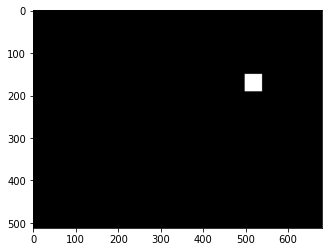

In [10]:
#Generate a square mask of size 100px x 100px
mask = create_mask(H,W,40,40)

#This mask will be laid over the input image as noise
plt.imshow(cv2.cvtColor(mask, cv2.COLOR_BGR2RGB));

### Preprocess the mask - Resizing
Note this step is not necessary since we passed the correct arguments to the create_mask fucntion

In [11]:
#This cell is not necessary since we gave the correct dimentions when creating the mask.
resized_mask = cv2.resize(mask, (W, H)) 
resized_mask = np.expand_dims(resized_mask, axis=-1)

### Load Image

This image will be altered using a mask. 

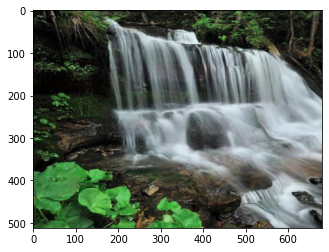

In [12]:
#Load Image
image = cv2.imread("data/test_image.png")

# Resize image to meet network expected input sizes
resized_image = cv2.resize(image, (W, H))

# Reshape to network input shape
#input_image = np.expand_dims(resized_image.transpose(2, 0, 1), 0)

plt.imshow(cv2.cvtColor(resized_image, cv2.COLOR_BGR2RGB));

### Generating the Masked Image

This is the multiplication of the image and the mask gives us the result of the masked image layered on top of the original image. 

The `masked_image` will be the first input to GMCNN model

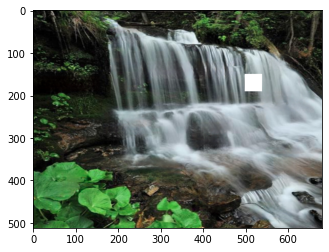

In [13]:
#Generating Masked_image
masked_image = (resized_image * (1 - mask) + 255 * mask).astype(np.uint8)
plt.imshow(cv2.cvtColor(masked_image, cv2.COLOR_BGR2RGB));

### Preprocessing function to aling with the ```input_shapes```

The model expects the input dimentions to be NCHW.

- masked_image.shape = (512,680,3) -----> model excepts = (1,3,512,680)
- resized_mask.shape = (512,680,1) -----> model excepts = (1,1,512,680)

In [14]:
#adding the batch size dimention and changing to NCHW format
def preprocess(inp):
    """
    Adding the batch size dimention and changing to NCHW format

    :param frame: input image
    :returns: processed image
    """
    inp = np.transpose(inp, (2, 0, 1))
    inp = np.expand_dims(inp, axis=0)
    
    return inp

In [15]:
masked_image = preprocess(masked_image)
resized_mask = preprocess(resized_mask)

In [16]:
result = exec_net.infer({input_keys[0]: masked_image,input_keys[1]:resized_mask})

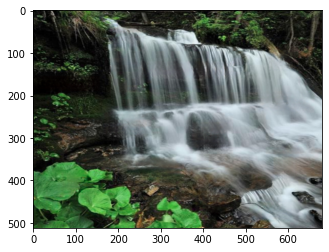

In [17]:
plt.imshow(cv2.cvtColor(np.transpose(result['Minimum'].astype(np.uint8)[0],(1,2,0)),cv2.COLOR_BGR2RGB));